In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm_notebook as tqdm
import pickle as pickle
from support import *
from features.feature_ts import genX
from experiment.algorithms.cluster_prep import *

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\os.py
c:\Users\Jason\thesis_project


In [2]:
X = genX([1994,2014], drop_0 = True) # Load dataframe

dropping all zero rows


In [3]:
# Only look at weekdays
df = X.copy()
df.reset_index(inplace = True)

# extract weekdays
df['day_names'] = df.date.dt.day_name()

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']

df['daytype'] = df.day_names.where(~df.day_names.isin(weekdays), 'weekday')

df.drop(['day_names'], axis = 1, inplace = True)

df_weekdays = df[df['daytype'] == 'weekday'] # Create dataframe with only weekdays

df_weekdays.set_index(['ProfileID'], inplace=True)
df_weekdays.drop(['daytype'],axis = 1, inplace = True)

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [4]:
mean = df_weekdays.groupby(["ProfileID"]).mean()

# Calculate the energy between 9-5

In [5]:
i = np.arange(9,17)
sum_df = pd.DataFrame(index = mean.index, columns = ["9_to_5", 'total'])
sum_df = sum_df.fillna(0)
for x in i:
    temp = mean.iloc[:,x]
    sum_df['9_to_5'] = sum_df['9_to_5'] + temp

sum_df['total'] =  mean.sum(axis = 1)

In [6]:
sum_df["percentage"] = (sum_df["9_to_5"]/sum_df["total"]) * 100

In [7]:
def check_9_to_5(df):
    if df > 50:
        return 'B'
    else: 
        return 'R'

In [8]:
sum_df['Labels'] = sum_df['percentage'].apply(check_9_to_5)

In [9]:
# 173 households labeled as Businesses for the 9-to-5 check
sum_df[sum_df['percentage'] > 50]

,9_to_5,total,percentage,Labels
ProfileID,,,,
217,26.131673,46.794261,55.843756,B
232,38.626513,76.085126,50.767497,B
284,20.822542,39.904126,52.181426,B
294,3.974973,7.621575,52.154223,B
306,9.190674,18.363042,50.049846,B
...,...,...,...,...
12027862,1.426371,2.773840,51.422269,B
12027927,23.003779,42.168680,54.551812,B
12028403,6.007670,7.263800,82.706982,B


# Look at ToPs, label households

In [10]:
top_df = pd.DataFrame()

top_df['Time'] = mean.idxmax(axis=1)

In [11]:
def check_top(df):
    if int(df) > 9 and int(df) < 17:
        return 'B'
    else:
        return 'R'    

In [12]:
top_df['Labels'] = top_df['Time'].apply(check_top)

In [13]:
len(top_df[top_df['Labels'] == 'B'])

842

# Look at AMC, label households

In [14]:
Xbin = xBins(X, 'amd')

In [15]:
ids = Xbin['1000-4000']

KeyError: '1000-4000'

In [15]:
amc_df = pd.DataFrame(index = mean.index.unique(), columns = ['Labels'])

In [16]:
amc_df.loc[ids] = 'B'

NameError: name 'ids' is not defined

In [ ]:
amc_df.loc[~amc_df.index.isin(ids)] = 'R'

In [ ]:
amc_df['Labels'].unique()

# Look at midday and late afternoon usage, label households

In [ ]:
# mid = 20
# late = 25

# lst = [mid,late]

# diff = np.abs(mid - late)

# perc = (diff/max(lst))*100

In [ ]:
# def mid_late_perc(df):
#     mid = df.mid
#     late = df.late

#     lst = [mid, late]

#     diff = np.abs(mid - late)

#     return (diff/max(lst))*100

In [ ]:
# mid_i = np.arange(12,15)
# late_i = np.arange(15,18)
# mid_late_df = pd.DataFrame(index = mean.index, columns = ["mid", 'late'])
# mid_late_df = mid_late_df.fillna(0)
# for x in mid_i:
#     temp1 = mean.iloc[:,x]
#     mid_late_df['mid'] = mid_late_df['mid'] + temp1

# for y in late_i:
#     temp2 = mean.iloc[:,x]
#     mid_late_df['late'] = mid_late_df['late'] + temp2


In [ ]:
# mid_late_df['perc'] = mid_late_df.apply(mid_late_perc, axis = 1)

In [ ]:
# def mid_late_labeler(df):
#     if df > 1:
#         return 'R'
#     else:
#         return 'B'


In [ ]:
# mid_late_df['Label'] = mid_late_df['perc'].apply(mid_late_labeler)

In [ ]:
# len(mid_late_df[mid_late_df['Label'] == 'B'])

# Determine how many theoretical businesses are there

In [17]:
new_df = pd.DataFrame()

new_df['ToP'], new_df['Sum'] = top_df['Labels'], sum_df['Labels']# amc_df['Labels'],new_df['AMC'], 

In [18]:
data_classes = ['R','B']
d = dict(zip(data_classes, range(0,2)))

new_df['ToP'],new_df['Sum'] = new_df['ToP'].map(d, na_action='ignore'),new_df['Sum'].map(d, na_action='ignore')#new_df['AMC'],new_df['AMC'].map(d, na_action='ignore'),

new_df['Total'] = new_df.sum(axis = 1)

new_df['Total'].unique()

array([0, 1, 2], dtype=int64)

In [19]:
len(new_df[new_df['Total'] == 0])

13963

In [30]:
business_ids = new_df[new_df['Total'] == 0].index.values

In [31]:
# # create a binary pickle file 
# f = open("business_ids2.pkl","wb")

# # write the python object (dict) to pickle file
# pickle.dump(business_ids,f)

# # close file
# f.close()

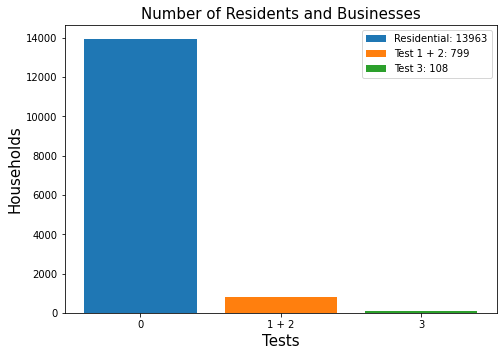

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# langs = [0,1,2,3]
# students = [len(new_df[new_df['Total'] == 0]),len(new_df[new_df['Total'] == 1]),len(new_df[new_df['Total'] == 2]),len(new_df[new_df['Total'] == 3])]
y1 = len(new_df[new_df['Total'] == 0])
y2 = len(new_df[new_df['Total'] == 1])
y3 = len(new_df[new_df['Total'] == 2])
y4 = len(new_df[new_df['Total'] == 3])
# ax.bar(langs,students)
plt.title("Number of Residents and Businesses", size = 15)
ax.bar(0,y1,label = "Residential: " + str(len(new_df[new_df['Total'] == 0])))
ax.bar(1,y2,label = "Test 1 + 2: " + str(len(new_df[new_df['Total'] == 1])))
ax.bar(2,y3,label = "Test 3: " + str(len(new_df[new_df['Total'] == 2])))
# ax.bar(3,y4,label = "Business: " + str(len(new_df[new_df['Total'] == 3])))
ax.set_xlabel("Tests", size = 15)
ax.set_ylabel("Households", size = 15)
ax.legend()
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['0', '1 + 2', '3'])
plt.show()

# Filter out the households that have two matches

In [ ]:
business_ids = new_df[new_df['Total'] >= 2].index.values

In [ ]:
business_ids

In [ ]:

# create a binary pickle file 
f = open("business_ids.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(business_ids,f)

# close file
f.close()

data = pd.read_pickle('business_ids.pkl') # Read pickle file

# Filter out large and small users

In [2]:
X = genX([1994,2014], drop_0 = True)
Xbin = xBins(X, 'amd')

dropping all zero rows


In [6]:
Xbin

{'0-1': array([     987,     1031,     2009,     7762,     7796,     8021,
         1002909,  1002939,  1004190,  1004891,  1006448,  1006511,
         1006512,  1006513, 12001515, 12001801, 12001974, 12005870],
       dtype=int64),
 '1-50': array([       2,       13,       39, ..., 12028598, 12028611, 12028616],
       dtype=int64),
 '50-150': array([      18,       20,       23, ..., 12028607, 12029049, 12029071],
       dtype=int64),
 '150-400': array([       1,        6,        7, ..., 12028932, 12028993, 12029006],
       dtype=int64),
 '400-600': array([       3,        4,        5, ..., 12029010, 12029019, 12029036],
       dtype=int64),
 '600-2500': array([      15,       16,       17, ..., 12029032, 12029045, 12029062],
       dtype=int64),
 '2500-4000': array([ 1005558,  1006685,  1006691, 12029058, 12029066], dtype=int64)}

In [8]:
large_ids = Xbin["2500-4000"]
small_ids = Xbin["0-1"]
large_small_ids = np.append(large_ids, small_ids)

In [12]:
# create a binary pickle file 
f = open("large_small_ids.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(large_small_ids,f)

# close file
f.close()

# data = pd.read_pickle('business_ids.pkl') # Read pickle file